# Deep Neural networks/Multi-layer perceptrons for Sedimentation rate[cm/yr] predictions 

## Make training features

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from os import walk
import pickle
from pathlib import Path
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [6]:
def find_nearest(value,vector):
    vector = np.float64(vector)-np.float64(value);
    return np.argmin(np.abs(vector))


,Latitude,Longitude,Sedimentation rate [cm/ka]
count,2782.000000,2782.000000,2782.000000
mean,35.049198,-1.334697,239.359548
std,32.949451,64.898774,432.437500
min,-68.133000,-179.650000,0.000000
25%,26.258250,-18.572475,3.010000
50%,43.150000,9.794000,50.000000
75%,58.752833,23.260125,310.000000
max,82.400000,179.733000,4800.000000


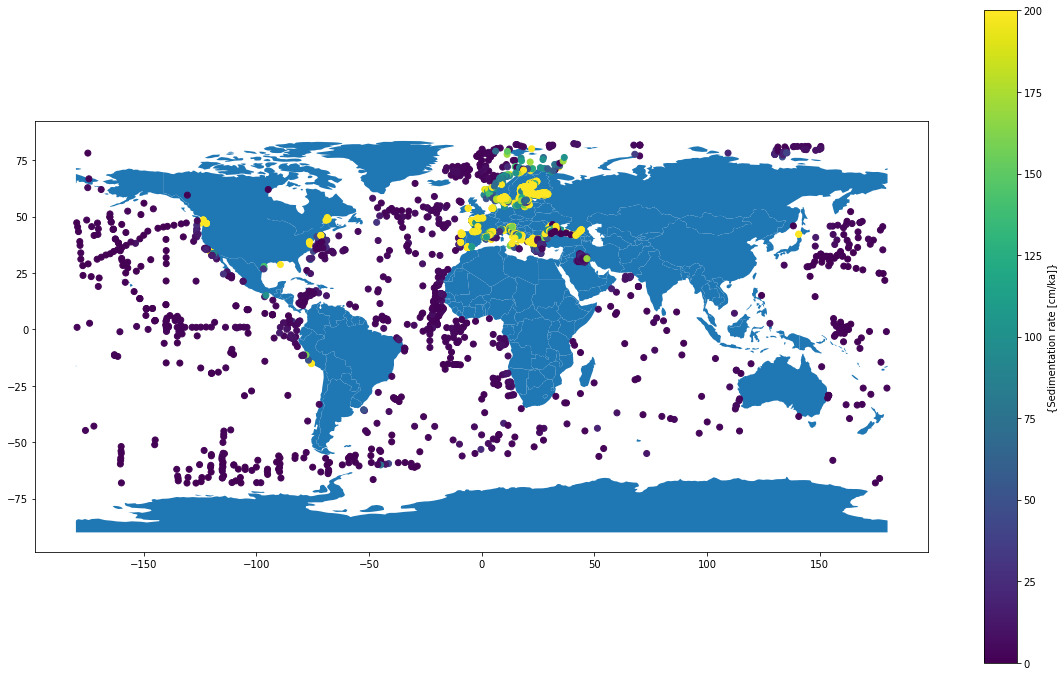

In [7]:
data_path = Path("/gxfs_work1/cau/sunms498/Data/RestrepoKNNsSed") 
sed_labels_file = "sediments_all_updated.xlsx"

df = pd.read_excel(Path(data_path / sed_labels_file))

df = df[["Latitude","Longitude","Sedimentation rate [cm/ka]"]]
df = df[df["Longitude"]>-180]
df = df.dropna(how="any")
df = df[df["Sedimentation rate [cm/ka]"]<5000]

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)  
gdf.plot(ax = world.plot(figsize = (20, 12)), column = df["Sedimentation rate [cm/ka]"], vmin = 0, vmax = 200,legend = True, legend_kwds={"label":"{Sedimentation rate [cm/ka]}"});

df.describe()

In this pipe, we read the features at each location(or the nearest location: *find_nearest*) and then store them as a file in a numpy array for each of the measurement location. The length of the numpy array depends on the limit of the sedimentation rate taken. Higher the number, more the number of measurements taken and hence bigger is the numpy array. 

Also here either *Data/Features_Phrampus* or *Data/Features_Phrampus_noNAN* can be used. *Data/Features_Phrampus* includes features that are not interpolated and hence some features contain Nan values which needs to be filtered out during training. Whereas *Data/Features_Phrampus_noNAN* contains interpolated features and hence none of the features contains nan values and hence does not need to be filtered during training. THe difference in the performance between these two needs to be found. Hence the pipeline here can be divided into two.

In [9]:
# feature_image_path ="../../../Data/LeeKNNsTOC/RestrepoFeatureMaps/"
restrepo_features_path = Path("/gxfs_work1/cau/sunms498/Data/Features_Phrampus")
#restrepo_features_path_flipped = Path("/media/sunms498/EXTERNAL_USB/Features_Phrampus_flipped")
restrepo_files = []

for (dirpath, dirnames, filenames) in walk(restrepo_features_path):
    restrepo_files.extend(filenames)

restrepo_files.sort()
len(restrepo_files)

print(filenames)

In [9]:
rootgrp = xr.open_dataset(Path(restrepo_features_path / restrepo_files[0]), format = 'netcdf4')
latitudes = rootgrp.variables['lat']
longitudes = rootgrp.variables['lon']

restrepo_features = np.empty([len(df),len(restrepo_files[0:len(restrepo_files)])])
restrepo_features[:] = np.nan
restrepo_X_mean = np.empty(0)
restrepo_X_std = np.empty(0)

file_idx = -1
corrupted_files = 0

for file in restrepo_files[0:len(restrepo_files)]:
    file_idx += 1
    try: 
        rootgrp = xr.open_dataset(Path(restrepo_features_path / file), format = 'NETCDF4')
    except:
        restrepo_X_mean = np.append(restrepo_X_mean,np.nan)
        restrepo_X_std = np.append(restrepo_X_std,np.nan)
        corrupted_files = corrupted_files + 1
        continue

    
#     latitudes = rootgrp.variables['lats'] # in theory all the same
#     longitudes = rootgrp.variables['lons']
    
    # dataset = rootgrp.variables['z']
    # if Features_Phrampus_noNAN is used just use rootgrp.variables['data']
    if file_idx == 182:
        dataset = rootgrp.variables['data']
    else:
        dataset = rootgrp.variables['z']
    restrepo_X_mean = np.append(restrepo_X_mean,np.nanmean(dataset))
    restrepo_X_std = np.append(restrepo_X_std,np.nanstd(dataset))
    # if file == "GL_LAND_IS_1.0_ETOPO2v2.5m.nc":
    #     dataset = rootgrp.variables['data']
    # else:
    #dataset = rootgrp.variables['data']

    for data_idx in range(0,len(df)):
        lat_idx = find_nearest(df.iloc[data_idx,0], latitudes)
        lon_idx = find_nearest(df.iloc[data_idx,1], longitudes)
        restrepo_features[data_idx, file_idx] = dataset[lat_idx, lon_idx]
        # latitudes_labels.append(latitudes[lat_idx])
        # longitudes_labels.append(longitudes[lon_idx])
    
    print("file " + str(file_idx) + " done!")
    
print("corrupted files: " + str(corrupted_files))
# chlor_features_path = Path(data_path / "FeaturesEwa")
# chlor_files = []

# for (dirpath, dirnames, filenames) in walk(chlor_features_path):
#     chlor_files.extend(filenames)

# chlor_files.sort()
# len(chlor_files)
# print(chlor_files)

file 0 done!
file 1 done!
file 2 done!
file 3 done!
file 4 done!
file 5 done!
file 6 done!
file 7 done!
file 8 done!
file 9 done!
file 10 done!
file 11 done!
file 12 done!
file 13 done!
file 14 done!
file 15 done!
file 16 done!
file 17 done!
file 18 done!
file 19 done!
file 20 done!
file 21 done!
file 22 done!
file 23 done!
file 24 done!
file 25 done!
file 26 done!
file 27 done!
file 28 done!
file 29 done!
file 30 done!
file 31 done!
file 32 done!
file 33 done!
file 34 done!
file 35 done!
file 36 done!
file 37 done!
file 38 done!
file 39 done!
file 40 done!
file 41 done!
file 42 done!
file 43 done!
file 44 done!
file 45 done!
file 46 done!
file 47 done!
file 48 done!
file 49 done!
file 50 done!
file 51 done!
file 52 done!
file 53 done!
file 54 done!
file 55 done!
file 56 done!
file 57 done!
file 58 done!
file 59 done!
file 60 done!
file 61 done!
file 62 done!
file 63 done!
file 64 done!
file 65 done!
file 66 done!
file 67 done!
file 68 done!
file 69 done!
file 70 done!
file 71 done!
fi

In [11]:
print("corrupted files: " + str(corrupted_files))

features = np.concatenate([restrepo_features], axis = 1)
X_mean = np.concatenate([restrepo_X_mean])
X_std = np.concatenate([restrepo_X_std])
features.shape


save_path = Path(Path() / "SedFeatures_nolimit")
np.save(Path(save_path / "numpy_features"), features)
np.save(Path(save_path / "numpy_labebels"), df["Sedimentation rate [cm/ka]"].values)
np.save(Path(save_path / "numpy_log+1_labebels"), np.log10(df["Sedimentation rate [cm/ka]"].values+1))
# np.save(Path(save_path / "numpy_latitudes_labels"), latitudes_labels)
# np.save(Path(save_path / "numpy_longitudes_labels"), longitudes_labels)
np.save(Path(save_path / "features_mean"),X_mean)
np.save(Path(save_path / "features_std"),X_std)

files = []
for file in restrepo_files:
    files.append(file)

# for file in chlor_files:
#     files.append(file)
    
with open(Path(save_path / "sorted_features.txt"), "wb") as fp:   #Pickling
    pickle.dump(files, fp)


corrupted files: 0


### *!!PARALLEL PIPELINE HERE FOR INCLUDING INTERPOLATED FEATURES!!*
Need not run if non-interpolated features needs to be used. Find out the interpolated files!

In [ ]:
# feature_image_path ="../../../Data/LeeKNNsTOC/RestrepoFeatureMaps/"
restrepo_features_path = Path("/gxfs_work1/cau/sunms498/Data/Features_Phrampus_noNaN")
#restrepo_features_path_flipped = Path("/media/sunms498/EXTERNAL_USB/Features_Phrampus_flipped")
restrepo_files = []

for (dirpath, dirnames, filenames) in walk(restrepo_features_path):
    restrepo_files.extend(filenames)

restrepo_files.sort()
len(restrepo_files)

rootgrp = xr.open_dataset(Path(restrepo_features_path / restrepo_files[0]), format = 'netcdf4')
latitudes = rootgrp.variables['lat']
longitudes = rootgrp.variables['lon']

restrepo_features = np.empty([len(df),len(restrepo_files[0:len(restrepo_files)])])
restrepo_features[:] = np.nan
restrepo_X_mean = np.empty(0)
restrepo_X_std = np.empty(0)

file_idx = -1
corrupted_files = 0

for file in restrepo_files[0:len(restrepo_files)]:
    file_idx += 1
    try: 
        rootgrp = xr.open_dataset(Path(restrepo_features_path / file), format = 'NETCDF4')
    except:
        restrepo_X_mean = np.append(restrepo_X_mean,np.nan)
        restrepo_X_std = np.append(restrepo_X_std,np.nan)
        corrupted_files = corrupted_files + 1
        continue

    
#     latitudes = rootgrp.variables['lats'] # in theory all the same
#     longitudes = rootgrp.variables['lons']
    
    # dataset = rootgrp.variables['z']
    # if Features_Phrampus_noNAN is used just use rootgrp.variables['data']
    dataset = rootgrp.variables['data']
    restrepo_X_mean = np.append(restrepo_X_mean,np.nanmean(dataset))
    restrepo_X_std = np.append(restrepo_X_std,np.nanstd(dataset))
    # if file == "GL_LAND_IS_1.0_ETOPO2v2.5m.nc":
    #     dataset = rootgrp.variables['data']
    # else:
    #dataset = rootgrp.variables['data']

    for data_idx in range(0,len(df)):
        lat_idx = find_nearest(df.iloc[data_idx,0], latitudes)
        lon_idx = find_nearest(df.iloc[data_idx,1], longitudes)
        restrepo_features[data_idx, file_idx] = dataset[lat_idx, lon_idx]
        # latitudes_labels.append(latitudes[lat_idx])
        # longitudes_labels.append(longitudes[lon_idx])
    
    print("file " + str(file_idx) + " done!")
    
print("corrupted files: " + str(corrupted_files))
# chlor_features_path = Path(data_path / "FeaturesEwa")
# chlor_files = []

# for (dirpath, dirnames, filenames) in walk(chlor_features_path):
#     chlor_files.extend(filenames)

# chlor_files.sort()
# len(chlor_files)
# print(chlor_files)

## Make Global features

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from os import walk
from pathlib import Path
import gc
from skimage.transform import resize
from time import sleep
from multiprocessing import pool


In [104]:
restrepo_input_path = Path("../../../Data/Features_Phrampus_noNaN/") 

restrepo_files = []

for (dirpath, dirnames, filenames) in walk(restrepo_input_path):
    restrepo_files.extend(filenames)
    break

restrepo_files.sort()
print(len(restrepo_files))

datasets = []
ii = 0
corrupted_files = 0

# land_file = Path(lee_input_path / "GL_LAND_IS_1.0_ETOPO2v2.5m.nc")
# rootgrp = xr.open_dataset(land_file)
# dataset = rootgrp['data']
# plt.imshow(dataset)

# np.save(Path(lee_input_path.parent / "is_land_map"), np.asarray(dataset).astype(np.bool))

1845


In [112]:
 #for idx in range(0, len(files)):
for file in restrepo_files[0:len(restrepo_files)]:   
    
    try: 

        rootgrp = xr.open_dataset(Path(restrepo_input_path / file), format = 'NETCDF4')
    except:
        datasets.append(np.nan)
        corrupted_files = corrupted_files + 1
        continue
    # if file == "POROSITY_global_prediction.grd":
    #     dataset = rootgrp.variables['z']
    # dataset = rootgrp.variables['data'] if Features_Phrampus_noNan is used
    if ii==182:
        dataset = rootgrp.variables['data']
        
    else:
        dataset = rootgrp.variables['data']
    
    #plt.imshow(dataset)
    #dataset = rootgrp.variables['z']
    datasets.append(dataset)
    ii+=1
    print("File " + str(ii) + " of " + str(len(restrepo_files)))
    
print(str(corrupted_files) + " corrupted files")

File 1846 of 1845
File 1847 of 1845
File 1848 of 1845
File 1849 of 1845
File 1850 of 1845
File 1851 of 1845
File 1852 of 1845
File 1853 of 1845
File 1854 of 1845
File 1855 of 1845
File 1856 of 1845
File 1857 of 1845
File 1858 of 1845
File 1859 of 1845
File 1860 of 1845
File 1861 of 1845
File 1862 of 1845
File 1863 of 1845
File 1864 of 1845
File 1865 of 1845
File 1866 of 1845
File 1867 of 1845
File 1868 of 1845
File 1869 of 1845
File 1870 of 1845
File 1871 of 1845
File 1872 of 1845
File 1873 of 1845
File 1874 of 1845
File 1875 of 1845
File 1876 of 1845
File 1877 of 1845
File 1878 of 1845
File 1879 of 1845
File 1880 of 1845
File 1881 of 1845
File 1882 of 1845
File 1883 of 1845
File 1884 of 1845
File 1885 of 1845
File 1886 of 1845
File 1887 of 1845
File 1888 of 1845
File 1889 of 1845
File 1890 of 1845
File 1891 of 1845
File 1892 of 1845
File 1893 of 1845
File 1894 of 1845
File 1895 of 1845
File 1896 of 1845
File 1897 of 1845
File 1898 of 1845
File 1899 of 1845
File 1900 of 1845
File 1901 

In [113]:
# chlor_features_path = Path(Path().resolve().parents[2] / "Data" / "LeeKNNsTOC" / "FeaturesEwa") 
# chlor_files = []

# for (dirpath, dirnames, filenames) in walk(chlor_features_path):
#     chlor_files.extend(filenames)

# chlor_files.sort()
# print(len(chlor_files))


#output_path = Path(Path().resolve().parents[2] / "Data" / "RestrepoKNNsSed" / "WorldFeaturesAll")#ChlorWorldFeatures
output_path = Path("../../../Data/RestrepoKNNsSed/WorldFeaturesAllPCAnoNan")


num_proc=16

chunks = 360 # dataset.shape[0]/chunks must be int
chunks_mp=360/num_proc
lat_step = np.int(dataset.shape[0]/chunks)

   
# for idx in range(0, len(datasets)):
#     feature_chunk = np.zeros([int(dataset.shape[0]/chunks * dataset.shape[1]), len(datasets)] )  
#     if datasets[idx] is not np.nan:
#         feature_chunk[:,idx] = np.asarray(datasets[idx][ii*lat_step:ii*lat_step + lat_step,:]).flatten(order = "C")
#     else:
#         feature_chunk[:,idx] = np.nan
                         

# np.save(Path(output_path / save_name) , feature_chunk)    
# print("Chunk " + str(ii+1) + " of " + str(chunks) + " written!")

/scratch/SlurmTMP/sunms498.5974599/ipykernel_1505782/1919046715.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat_step = np.int(dataset.shape[0]/chunks)


In [118]:
from sklearn.decomposition import PCA

for ii in range(0,chunks):

    feature_chunk = np.zeros([int(dataset.shape[0]/chunks * dataset.shape[1]), len(datasets)] )
        
    for idx in range(0, len(datasets)):
        
        if datasets[idx] is not np.nan:
            feature_chunk[:,idx] = np.asarray(datasets[idx][ii*lat_step:ii*lat_step + lat_step,:]).flatten(order = "C")
            # the code below choose minimum number of principal components such that 95 % of the variance is retained.
            # pca = PCA(0.95) 
            # pca.fit(feature_chunk)
            # feature_chunk=pca.transform(feature_chunk)
        else:
            feature_chunk[:,idx] = np.nan
                         
    save_name = "Sed_world_feature_" + str(ii).zfill(3)
    np.save(Path(output_path / save_name) , feature_chunk)    
    print("Chunk " + str(ii+1) + " of " + str(chunks) + " written!")


Chunk 1 of 360 written!


KeyboardInterrupt: 

In [119]:
print(feature_chunk.shape)
pca = PCA(0.95) 
pca.fit(feature_chunk)
feature_chunk=pca.transform(feature_chunk)
print(feature_chunk.shape)

(25920, 5535)
(25920, 3)


In [ ]:
print(str(corrupted_files) + " corrupted files")

plt.imshow(feature_chunk)


0 corrupted files


### Features that contain NaN values and hence removed

In [ ]:
# feature_image_path ="../../../Data/LeeKNNsTOC/RestrepoFeatureMaps/"
restrepo_features_path = Path("/gxfs_work1/cau/sunms498/Data/Features_Phrampus")
#restrepo_features_path_flipped = Path("/media/sunms498/EXTERNAL_USB/Features_Phrampus_flipped")
restrepo_files = []

for (dirpath, dirnames, filenames) in walk(restrepo_features_path):
    restrepo_files.extend(filenames)

restrepo_files.sort()
len(restrepo_files)

print(filenames[nan_rows])


## Train Neural Network

Here we would have three pipelines atleast: One for the regression, one for classification and one for bayesian neural network

### Monte carlo dropout: regression

In [3]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from os import path, makedirs
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=512)])
  except RuntimeError as e:
    print(e)

#tf.config.experimental.set_memory_growth(physical_devices[0], True) # solves some GPU memory issues 
np.random.seed(42)
tf.random.set_seed(42)

#print(physical_devices)

In [9]:
feature_path = Path(Path() / "SedFeaturesnoNAN_nolimit")
features = np.load(Path(feature_path / "numpy_features.npy"))
labels = np.load(Path(feature_path / "numpy_labebels.npy"))
X_mean = np.load(Path(feature_path / "features_mean.npy")).astype(float)
X_std = np.load(Path(feature_path / "features_std.npy")).astype(float)
#lat_labels = np.load(Path(feature_path / "numpy_latitudes_labels.npy")).astype(np.float)
#lon_labels = np.load(Path(feature_path / "numpy_longitudes_labels.npy")).astype(np.float)


#Norm Features
features = np.divide((features - X_mean),X_std)

with open(Path(feature_path / "sorted_features.txt"), "rb") as fp:
    feature_names = pickle.load(fp)

#feature_selection = pd.read_csv(Path("Selection_374_Chlor.csv")).values
# feature_selection = pd.read_csv(Path("restrepoHighResFeaturesRaw-50.txt")).values


#filter and clean features/labels
#Features from list
# selection_filter = np.zeros(features.shape[1], dtype=bool)
# for idx, feature_name in enumerate(feature_names):
#     if feature_name in feature_selection: # drop '.nc' from feature names #drop .grd
#         selection_filter[idx] = True

#Exclude Feature
#selection_filter = np.ones(features.shape[1])
# for idx, feature_name in enumerate(feature_names):
#     if feature_name[:-3] == "MY1DMM_CHLORA_2020-08-01":
#         selection_filter[idx] = 0

# selection_filter = selection_filter.astype(bool)

prediction_limit = 5000

# features = features[:,selection_filter]
features = features[labels<prediction_limit,:] #take only TOC < 5% 
# lat_labels = lat_labels[labels<prediction_limit]
# lon_labels = lon_labels[labels<prediction_limit]
labels = labels[labels<prediction_limit]
# labels[labels>prediction_limit] = prediction_limit

#Drop features with NaNs
nan_rows = np.isnan(features).any(axis=0)
np.save("FeatureNanRows",nan_rows)
features = features[:,~nan_rows]
print(nan_rows)


# #OR fill in NaNs with random
# nan_fill = np.random.rand(features.shape[0],features.shape[1])*2-1
# features[np.isnan(features)] = nan_fill[np.isnan(features)]

# suffle features/labels
shuffle_idx = np.random.mtrand.randint(low = 0, high = len(labels), size = len(labels))
features = features[shuffle_idx,:]
labels = labels[shuffle_idx]
print(features.shape)


#PCA
pca = PCA (0.95) #95% of the variance is retained
pca.fit(features)
features = pca.transform(features)
print(features.shape)

#taking the log of labels so that the order of maginitude between deep oceans and the coasts is reduced
#loglabels=np.log10(labels)

model = [None]*10
MAE = []
corrcoef = []
kf = KFold(n_splits=10)
mc_samples = 50


[False False False ... False False False]
(2782, 1845)


(2782, 67)

In [27]:
#early stopping and LR-scheduling callbacks
#checkpoint_cb = keras.callbacks.ModelCheckpoint('TOC_nn.h5', save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor = "loss", patience = 200, restore_best_weights = True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor = "loss", factor = 0.8, patience = 40, min_lr = 0.000001)
do_rate = 0.2
num_nodes = 50
    
model_seed = keras.models.Sequential()
model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
#model_seed.add(keras.layers.Dropout(do_rate))
model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
#model_seed.add(keras.layers.Dropout(do_rate))
model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
#model_seed.add(keras.layers.Dropout(do_rate))
model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
#model_seed.add(keras.layers.Dropout(do_rate))
model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
#model_seed.add(keras.layers.Dropout(do_rate))
model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
#model_seed.add(keras.layers.Dropout(do_rate))




model_seed.add(keras.layers.Dense(num_nodes, activation = "relu", kernel_initializer = "he_normal"))





model_seed.add(keras.layers.Dense(1, activation = "relu"))

model_seed.build([None,features.shape[1]])


In [28]:
#%%timeit -n 1 -r 1
#fold = 0
#for train, test in kf.split(features, labels): #startification/10fold
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, random_state=1)    
#print("computing fold " + str(fold+1))




model = keras.models.clone_model(model_seed)
model.set_weights(model_seed.get_weights())
model.compile(loss = "mean_absolute_error",
             optimizer = keras.optimizers.Nadam(learning_rate = 0.01),
             metrics = [["RootMeanSquaredError"]])
 
#Final run with early stopping callback
print("running main training round")
 
 
history = model.fit(features_train, labels_train,  epochs = 10000, batch_size= 70, 
                      callbacks = [ early_stopping_cb,lr_scheduler],verbose =2,validation_split=0.2)#
 
#MC Dropout
probs_stack = np.stack([model(features_test,training = True) for sample in range(mc_samples)]) 
probs_stack = probs_stack.reshape([probs_stack.shape[0],probs_stack.shape[1]])
np.savetxt("probs_stack_regression.txt", probs_stack.T)
np.savetxt("labels_test_regression.txt", labels_test)
predictions = tf.squeeze(probs_stack.mean(axis = 0))
np.savetxt("predictions_regression.txt", predictions)
corrcoef.append(np.corrcoef(predictions, labels_test)[0,1])
MAE.append(mean_absolute_error(labels_test,predictions))
 
history_df = pd.DataFrame(history.history)#
#print(history_df)
#print("best val accuracy: " + str(np.max(history_df.val_accuracy)))
print("test MAE:" + str(MAE))
print("test correlation coeficient:" + str(corrcoef))
print("     ----     ")
#fold = fold+1


running main training round
Epoch 1/10000
26/26 - 5s - loss: 205.6950 - root_mean_squared_error: 462.7942 - val_loss: 554.4567 - val_root_mean_squared_error: 1067.8531
Epoch 2/10000
26/26 - 0s - loss: 146.0331 - root_mean_squared_error: 374.5507 - val_loss: 1072.4871 - val_root_mean_squared_error: 1876.0752
Epoch 3/10000
26/26 - 0s - loss: 132.2934 - root_mean_squared_error: 347.9187 - val_loss: 610.3632 - val_root_mean_squared_error: 1167.5590
Epoch 4/10000
26/26 - 0s - loss: 135.0994 - root_mean_squared_error: 356.6416 - val_loss: 413.5706 - val_root_mean_squared_error: 774.4363
Epoch 5/10000
26/26 - 0s - loss: 127.6115 - root_mean_squared_error: 344.6490 - val_loss: 340.1712 - val_root_mean_squared_error: 669.7759
Epoch 6/10000
26/26 - 0s - loss: 125.7543 - root_mean_squared_error: 338.0166 - val_loss: 264.4881 - val_root_mean_squared_error: 527.2711
Epoch 7/10000
26/26 - 0s - loss: 122.6974 - root_mean_squared_error: 339.6848 - val_loss: 282.6691 - val_root_mean_squared_error: 566.

### *Results*

**Changing the network configurations(batch norm + drop out), with or without nan values**
1. SedFeatures_nolimit(351 features used) 50 nodes 6 layers deep, training data limit 5000 cm/yr(bn+do)
    Epoch 1955/10000
    26/26 - 0s - loss: 85.0025 - root_mean_squared_error: 271.1098 - val_loss: 110.4581 - val_root_mean_squared_error: 279.9966
    test MAE:[103.51716275718482]
    test correlation coeficient:[0.6134670132778584]
         ----     
2. SedFeaturesnoNAN_nolimit(1851 features used(Nan values in the features interpolated using nearest neighbour algorithm) 50 nodes 6 layers deep, training data limit 5000 cm/yr (bn +do)
    Epoch 1624/10000
    26/26 - 0s - loss: 74.3069 - root_mean_squared_error: 245.7925 - val_loss: 95.0043 - val_root_mean_squared_error: 253.0488
    test MAE:[107.98556418310604]
    test correlation coeficient:[0.6092894246458052]
         ----

3. SedFeaturesnoNAN_nolimit(1851 features used(Nan values in the features interpolated using nearest neighbour algorithm) 50 nodes 6 layers deep, training data limit 5000 cm/yr (only bn)
    Epoch 2221/10000
    26/26 - 0s - loss: 35.1323 - root_mean_squared_error: 128.8497 - val_loss: 102.3195 - val_root_mean_squared_error: 321.6432
    test MAE:[99.18582544703911]
    test correlation coeficient:[0.6619578948760129]
         ----
Some getaways from the results: including the features that contain the nan values should be okay, since the MAE and rhe correlation coefficient for the same network architecture is similar.

Including a limit, does not sound right, since it is like manupulating the data. But in case of softmax classification, this could be a problem and needs to be identified. 

B. Layers(num of layers = num of hidden layers(excluding the input and the output layers))
1. SedFeaturesnoNAN_nolimit(1851 features used(Nan values in the features interpolated using nearest neighbour algorithm) 50 nodes 8 layers deep, training data limit 5000 cm/yr (only bn)  (change in the depth)
    Epoch 2554/10000
    26/26 - 0s - loss: 38.6394 - root_mean_squared_error: 123.4571 - val_loss: 103.0059 - val_root_mean_squared_error: 370.6750
    test MAE:[109.97509453809599]
    test correlation coeficient:[0.5892338337968344]
         ----     
         
2. SedFeaturesnoNAN_nolimit(1851 features used(Nan values in the features interpolated using nearest neighbour algorithm) 50 nodes 10 layers deep, training data limit 5000 cm/yr (only bn)  (change in the depth)
    Epoch 2157/10000
    26/26 - 0s - loss: 50.5200 - root_mean_squared_error: 170.8775 - val_loss: 103.7233 - val_root_mean_squared_error: 291.4396
    test MAE:[113.92433735268993]
    test correlation coeficient:[0.443199497995542]
         ----     
         
3. SedFeaturesnoNAN_nolimit(1851 features used(Nan values in the features interpolated using nearest neighbour algorithm) 50 nodes 12 layers deep, training data limit 5000 cm/yr (only bn)  (change in the depth)
    Epoch 1103/10000
    26/26 - 0s - loss: 69.5835 - root_mean_squared_error: 209.6966 - val_loss: 1832211972096.0000 - val_root_mean_squared_error: 38650553303040.0000
    test MAE:[112.45764947487876]
    test correlation coeficient:[0.5513549825234974]
    
    Validation rmse and loss had very high peaks at times.
         ----  
         
4. SedFeaturesnoNAN_nolimit(1851 features used(Nan values in the features interpolated using nearest neighbour algorithm) 50 nodes 4 layers deep, training data limit 5000 cm/yr (only bn)  (change in the depth)
    Epoch 1879/10000
    26/26 - 0s - loss: 40.8177 - root_mean_squared_error: 138.1012 - val_loss: 118.6943 - val_root_mean_squared_error: 596.7034
    test MAE:[103.52762094406486]
    test correlation coeficient:[0.56552038419244]
    
    Validation loss and rmse is higher than the training loss and rmse. Overfitting?
         ----     
    
         ----    


C. Nodes
1. (1a)SedFeaturesnoNAN_nolimit(1851 features used(Nan values in the features interpolated using nearest neighbour algorithm) 100 nodes 6 layers deep, training data limit 5000 cm/yr (only bn)  (change in the width)
    Epoch 2420/10000
    26/26 - 0s - loss: 31.7882 - root_mean_squared_error: 112.2182 - val_loss: 91.4860 - val_root_mean_squared_error: 297.6118
    test MAE:[100.57475600563734]
    test correlation coeficient:[0.6560589215574856]

2. SedFeaturesnoNAN_nolimit(1851 features used(Nan values in the features interpolated using nearest neighbour algorithm) 25 nodes 6 layers deep, training data limit 5000 cm/yr (only bn)  (change in the width)
    Epoch 1755/10000
    26/26 - 0s - loss: 43.1965 - root_mean_squared_error: 153.7391 - val_loss: 93.0986 - val_root_mean_squared_error: 276.6871
    test MAE:[107.93581486824351]
    test correlation coeficient:[0.5070508981426107]
         ----  
         
3. (1b)SedFeaturesnoNAN_nolimit(1851 features used(Nan values in the features interpolated using nearest neighbour algorithm) 100 nodes 6 layers deep, training data limit 5000 cm/yr (only bn)  (change in the width)
    Epoch 2458/10000
    26/26 - 0s - loss: 37.2679 - root_mean_squared_error: 125.4498 - val_loss: 108.3787 - val_root_mean_squared_error: 477.6844
    test MAE:[105.746994431413]
    test correlation coeficient:[0.6148087792939698]
    ----
   
2. SedFeaturesnoNAN_nolimit(1851 features used(Nan values in the features interpolated using nearest neighbour algorithm) 200 nodes 6 layers deep, training data limit 5000 cm/yr (only bn)  (change in the width)
    Epoch 2119/10000
    26/26 - 0s - loss: 32.5883 - root_mean_squared_error: 121.4498 - val_loss: 102.3814 - val_root_mean_squared_error: 382.6426
    test MAE:[102.14547329419135]
    test correlation coeficient:[0.6671297795065216]
    
    validation rmse and loss still has very high peaks sometimes.
         ----     


D. with PCA

1. SedFeaturesnoNAN_nolimit(1851 features used(Nan values in the features interpolated using nearest neighbour algorithm) 50 nodes 6 layers deep, training data limit 5000 cm/yr (only bn)
    ****PCA = 0.95****  
    Epoch 1916/10000
    26/26 - 0s - loss: 35.8045 - root_mean_squared_error: 131.7885 - val_loss: 101.4987 - val_root_mean_squared_error: 373.7163
    test MAE:[106.31353617694822]
    test correlation coeficient:[0.6126092566599333]
         ----  

In [30]:
features.shape

(2782, 68)

Correlation Coefficient: 0.6126092566599333
MAE: 106.31353617694822
0.6126092566599333
(2782,)
(557,)


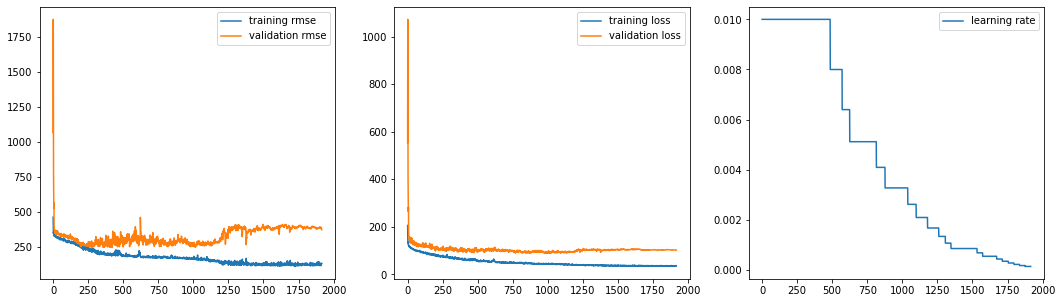

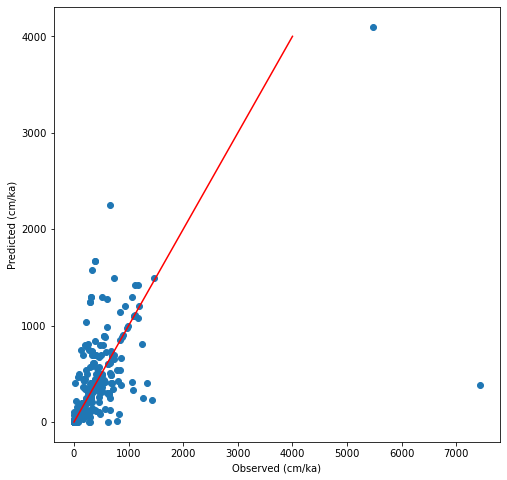

In [29]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=[18,5])
plt.subplot(131)
plt.plot(history_df.root_mean_squared_error)
plt.plot(history_df.val_root_mean_squared_error)
plt.legend(["training rmse", "validation rmse"])
plt.subplot(132)
plt.plot(history_df.loss)
plt.plot(history_df.val_loss)
plt.legend(["training loss", "validation loss"])
plt.subplot(133)
plt.plot(history_df.lr)
plt.legend(["learning rate"])

print("Correlation Coefficient: "+str(np.sum(corrcoef)/len(corrcoef)))
print("MAE: " +str(np.sum(MAE)/len(MAE)))


plt.figure(figsize=[8,8])
#plt.clf()
plt.scatter(predictions,labels_test)
x = np.linspace(0,4000)
plt.plot(x, x, 'r')
plt.xlabel("Observed (cm/ka)")
plt.ylabel("Predicted (cm/ka)")
print(np.corrcoef(predictions,labels_test)[0,1])

dirname = Path("Sed_regresion_083_RestrepoFeats_AllVS0.2_Test")
if not path.isdir(dirname):
    makedirs(dirname)
 
#for idx, model in enumerate(model):
model_name = "Model_nolimitnonan_Test"  + ".h5"
model.save(Path(dirname / model_name))
    
print(labels.shape)
print(labels_test.shape)

#error=[]
#error = np.abs(model.predict(features[:,:])[:,0]-labels)
#error = np.array(error)

#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#df = pd.DataFrame({'Latitude': lat_labels, 'Longitude':lon_labels, 'Error': error})
#geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
#gdf = GeoDataFrame(df, geometry=geometry)  
#gdf.plot(ax = world.plot(figsize = (20, 12)), column = df["Error"],legend = True, legend_kwds={"label":"{error in prediction}"});


#execfile("Make_Global_Predictions_regression.py")



### Softmax classification

In [16]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from os import path, makedirs
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
#physical_devices = tf.config.list_physical_devices('GPU') 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=512)])
  except RuntimeError as e:
    print(e)

In [4]:
#tf.config.experimental.set_memory_growth(physical_devices[0], True) # solves some GPU memory issues 
np.random.seed(42)
tf.random.set_seed(42)

#print(physical_devices)

feature_path = Path(Path() / "SedFeatures_nolimit")
features = np.load(Path(feature_path / "numpy_features.npy"))
labels = np.load(Path(feature_path / "numpy_labebels.npy"))
X_mean = np.load(Path(feature_path / "features_mean.npy")).astype(float)
X_std = np.load(Path(feature_path / "features_std.npy")).astype(float)
#lat_labels = np.load(Path(feature_path / "numpy_latitudes_labels.npy")).astype(np.float)
#lon_labels = np.load(Path(feature_path / "numpy_longitudes_labels.npy")).astype(np.float)

#Norm Features
features = np.divide((features - X_mean),X_std)

with open(Path(feature_path / "sorted_features.txt"), "rb") as fp:
    feature_names = pickle.load(fp)


In [5]:
prediction_limit = 5000 #!!!!!NOT taking till 5000

# features = features[:,selection_filter]
features = features[labels<prediction_limit,:] #take only TOC < 5% 
#lat_labels = lat_labels[labels<prediction_limit]
#lon_labels = lon_labels[labels<prediction_limit]
labels = labels[labels<prediction_limit]
# labels[labels>prediction_limit] = prediction_limit

#Drop features with NaNs
nan_rows = np.isnan(features).any(axis=0)
np.save("FeatureNanRows",nan_rows)
features = features[:,~nan_rows]



shuffle_idx = np.random.mtrand.randint(low = 0, high = len(labels), size = len(labels))
features = features[shuffle_idx,:]
labels = labels[shuffle_idx]
print("features.shape: ")
print(features.shape) 

features.shape: 
(2782, 352)


0.0
4800.0


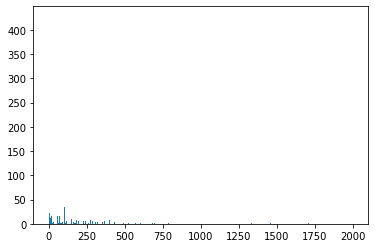

In [6]:
bin_range = [0, prediction_limit]
class_bins = 2000

class_labels = np.round((labels-np.min(labels))/np.max(labels)*class_bins)
class_labels[class_labels>class_bins-1] = class_bins-1

print(np.min(labels))
print(np.max(labels))

#Create class weights
histogram = np.histogram(class_labels, bins = class_bins)[0]
histogram[histogram<=1] = 2
class_weights = dict(enumerate(1/np.log(histogram)))
#class_weights = dict(enumerate(np.ones_like(histogram)))



plt.hist(class_labels, bins= class_bins)

# #OR fill in NaNs with random
# nan_fill = np.random.rand(features.shape[0],features.shape[1])*2-1
# features[np.isnan(features)] = nan_fill[np.isnan(features)]



#taking the log of labels so that the order of maginitude between deep oceans and the coasts is reduced
#loglabels=np.log10(labels)

model_per_fold = [None]*10
acc_per_fold = []
corrcoef_per_fold = []
MAE_per_fold = []

kf = StratifiedKFold(n_splits=10)
mc_samples = 50

In [7]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor = "accuracy", patience = 500, restore_best_weights = True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor = "accuracy", factor = 0.8, patience = 50, min_lr = 0.000001)
do_rate = 0.2
    
model_seed = keras.models.Sequential()
model_seed.add(keras.layers.Dense(50, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
model_seed.add(keras.layers.Dropout(do_rate))
model_seed.add(keras.layers.Dense(50, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
model_seed.add(keras.layers.Dropout(do_rate))
model_seed.add(keras.layers.Dense(50, activation = "relu", kernel_initializer = "he_normal"))
model_seed.add(keras.layers.BatchNormalization())
model_seed.add(keras.layers.Dropout(do_rate))
model_seed.add(keras.layers.Dense(50, activation = "relu", kernel_initializer = "he_normal"))
# model_seed.add(keras.layers.BatchNormalization())
# model_seed.add(keras.layers.Dropout(do_rate))
# model_seed.add(keras.layers.Dense(256, activation = "relu", kernel_initializer = "he_normal"))
# model_seed.add(keras.layers.BatchNormalization())
# model_seed.add(keras.layers.Dropout(do_rate))
# model_seed.add(keras.layers.Dense(256, activation = "relu", kernel_initializer = "he_normal"))
# model_seed.add(keras.layers.BatchNormalization())
# model_seed.add(keras.layers.Dropout(do_rate))
# model_seed.add(keras.layers.Dense(256, activation = "relu", kernel_initializer = "he_normal"))
# model_seed.add(keras.layers.BatchNormalization())
# model_seed.add(keras.layers.Dropout(do_rate))
# model_seed.add(keras.layers.Dense(256, activation = "relu", kernel_initializer = "he_normal"))
# model_seed.add(keras.layers.BatchNormalization())
# model_seed.add(keras.layers.Dropout(do_rate))
# model_seed.add(keras.layers.Dense(500, activation = "relu", kernel_initializer = "he_normal"))
# model_seed.add(keras.layers.BatchNormalization())
# model_seed.add(keras.layers.Dropout(do_rate))
# model_seed.add(keras.layers.Dense(500, activation = "relu", kernel_initializer = "he_normal"))
#model_seed.add(keras.layers.BatchNormalization())
model_seed.add(keras.layers.Dense(class_bins, activation = "softmax"))

model_seed.build([None,features.shape[1]])


2022-09-15 14:46:58.955780: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 14:46:58.955960: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Questions: do we need to do k-fold. 
Since there are more values close to zero, makes sense to make more bins near zero and less farther away, so use a log scale of bins?
monte carlo dropout+softmax helps?

In [8]:
fold = 0
for train, test in kf.split(features, class_labels): #startification/10fold
    
    print("computing fold " + str(fold+1))
    
    model_per_fold[fold] = keras.models.clone_model(model_seed)
    model_per_fold[fold].set_weights(model_seed.get_weights())
    model_per_fold[fold].compile(loss = "sparse_categorical_crossentropy",
                optimizer = keras.optimizers.Nadam(learning_rate = 0.01),
                metrics = ["accuracy"])

    #Final run with early stopping callback
    print("running main training round")
#     history = model.fit(features[train,:], class_labels[train],  epochs = 10000, batch_size= 70, 
#                         class_weight=class_weights,callbacks = [early_stopping_cb, lr_scheduler], verbose = 1)
    history =  model_per_fold[fold].fit(features[train,:], class_labels[train],  epochs = 2000, batch_size= 70, 
                       callbacks = [early_stopping_cb, lr_scheduler], verbose = 1)
    
    #MC Dropout
    probs_stack = np.stack([ model_per_fold[fold](features[test,:],training = True) for sample in range(mc_samples)]) #why do we do mc dropout again?
    probs = probs_stack.mean(axis = 0)
    probs_max = np.max(probs,axis = 1)
    
    predictions = tf.argmax(probs,axis=1)
    
    corrcoef_per_fold.append(np.corrcoef(predictions, class_labels[test])[0,1])
    acc_per_fold.append(np.sum(tf.cast((predictions == class_labels[test]), tf.float32))/predictions.shape[0])
    MAE_per_fold.append(mean_absolute_error(class_labels[test],predictions))
    
    history_df = pd.DataFrame(history.history)
   #print("best val accuracy: " + str(np.max(history_df.val_accuracy)))
    print("test accuracy:" + str(acc_per_fold[fold]))
    print("test correlation coeficient:" + str(corrcoef_per_fold[fold]))
    print("     ----     ")
    fold = fold+1


/gxfs_home/cau/sunms498/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
2022-09-15 14:47:04.630818: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-15 14:47:04.645032: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2900000000 Hz


computing fold 1
running main training round
Epoch 1/2000
36/36 [==============================] - 6s 11ms/step - loss: 5.3050 - accuracy: 0.1500
Epoch 2/2000
36/36 [==============================] - 0s 5ms/step - loss: 3.3761 - accuracy: 0.2162
Epoch 3/2000
36/36 [==============================] - 0s 5ms/step - loss: 3.0880 - accuracy: 0.2621
Epoch 4/2000
36/36 [==============================] - 0s 11ms/step - loss: 3.0717 - accuracy: 0.2580
Epoch 5/2000
36/36 [==============================] - 0s 5ms/step - loss: 2.9651 - accuracy: 0.2649
Epoch 6/2000
36/36 [==============================] - 0s 4ms/step - loss: 2.8802 - accuracy: 0.2971
Epoch 7/2000
36/36 [==============================] - 0s 7ms/step - loss: 2.8337 - accuracy: 0.2878
Epoch 8/2000
36/36 [==============================] - 0s 13ms/step - loss: 2.7718 - accuracy: 0.2977
Epoch 9/2000
36/36 [==============================] - 0s 5ms/step - loss: 2.7431 - accuracy: 0.2863
Epoch 10/2000
36/36 [==============================]

KeyboardInterrupt: 

NameError: name 'acc_per_fold' is not defined

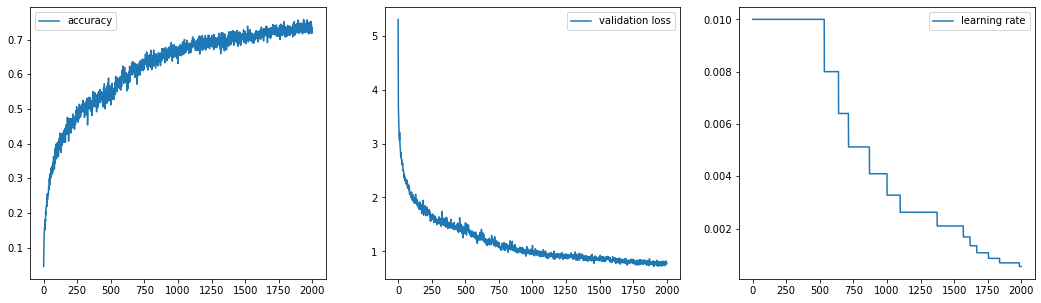

In [18]:
#history_df = pd.DataFrame(history.history)
file_name = "history.pkl"
history_df = pd.read_pickle(file_name)

plt.figure(figsize=[18,5])
plt.subplot(131)
plt.plot(history_df.accuracy)
#plt.plot(history_df.val_root_mean_squared_error)
plt.legend(["accuracy"])
plt.subplot(132)
plt.plot(history_df.loss)
#plt.plot(history_df.val_loss)
plt.legend(["validation loss"])
plt.subplot(133)
plt.plot(history_df.lr)
plt.legend(["learning rate"])

print("Correlation Coefficient: "+str(np.sum(corrcoef_per_fold)/len(corrcoef_per_fold)))
print("accuracy: " +str(np.sum(acc_per_fold)/len(acc_per_fold)))
print("MAE: " +str(np.sum(MAE_per_fold)/len(MAE_per_fold)))

In [15]:
probs_stack

0.0009999999

In [19]:
#print(probs_stack.shape)
probs_stack = np.mean(probs_stack, axis = 0)
probs_stack = probs_stack.reshape([probs_stack.shape[0],probs_stack.shape[1]])
#print(probs_stack.shape)
np.savetxt("probs_stack_softmax.txt", probs_stack)
np.savetxt("labels_test_softmax.txt", class_labels[test]*np.max(labels)/class_bins)
np.savetxt("predictions_softmax.txt", predictions*np.max(labels)/class_bins)


plt.figure(figsize=[8,8])
#plt.clf()
plt.scatter(predictions,class_labels[test])
plt.xlabel("Observed (cm/ka)")
plt.ylabel("Predicted (cm/ka)")
print(np.corrcoef(predictions,class_labels[test])[0,1])

dirname = Path("Sed_softmax_RestrepoFeats_noLimit")
if not path.isdir(dirname):
    makedirs(dirname)
 
 
for idx, model in enumerate(model_per_fold):
    model_name = "fold_" + str(idx) + ".h5"
    model.save(Path(dirname / model_name))

NameError: name 'probs_stack' is not defined

## Make global predictions

### regression/mc dropout

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
physical_devices = tf.config.list_physical_devices('GPU') # solves some GPU memory issues 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
from os import walk
from pathlib import Path
import matplotlib.pyplot as plt
# from matplotlib import cm 
#%matplotlib notebook
import gc
# import xarray as xr
from pandas import read_csv
import pickle


2022-10-12 10:48:05.524721: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [16]:
model_path = 'Sed_regresion_083_RestrepoFeats_AllVS0.2_Test' 
model_files = []
for (dirpath, dirnames, model_file) in walk(model_path):
    model_files.extend(model_file)
models = [None]*len(model_files)
for idx, model in enumerate(model_files):
    models[idx] = keras.models.load_model(Path(Path(model_path) / model))
    
feature_path = Path(Path() / "SedFeaturesnoNAN_nolimit") #ChlorFeatures
X_mean = np.load(Path(feature_path / "features_mean.npy")).astype(np.float)
X_std = np.load(Path(feature_path / "features_std.npy")).astype(np.float)

#dataset_path = Path(Path().resolve().parents[2] / "Data" / "LeeKNNsTOC" / "WorldFeaturesAll")#ChlorWorldFeatures
dataset_path = Path("../../../Data/RestrepoKNNsSed/WorldFeaturesAllnoNaN")
files = []

for (dirpath, dirnames, filenames) in walk(dataset_path):
    files.extend(filenames)
    break

files.sort()
features = np.load(Path(dataset_path / files[0]))
#PCA
# pca = PCA (0.95) #95% of the variance is retained
# pca.fit(features)
# features = pca.transform(features)
print(features.shape)
#feature_path = Path(Path() / "SedFeatures") #ChlorFeatures
with open(Path(feature_path / "sorted_features.txt"), "rb") as fp:
    feature_names = pickle.load(fp)

# feature_selection = read_csv("Selection_374_Chlor.csv").values
# feature_selection = read_csv("restrepoHighResFeaturesRaw-50.txt").values



# selection_filter = np.zeros(features.shape[1], dtype=bool)
# print(len(selection_filter))
# for idx, feature_name in enumerate(feature_names):
#     if feature_name in feature_selection: # drop '.nc' from feature names
#         selection_filter[idx] = True
        

(25920, 1845)


/scratch/SlurmTMP/sunms498.5974599/ipykernel_1505782/2866285343.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_mean = np.load(Path(feature_path / "features_mean.npy")).astype(np.float)
/scratch/SlurmTMP/sunms498.5974599/ipykernel_1505782/2866285343.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_std = np.load(Path(feature_p

In [15]:
X_mean.shape

(1845,)

In [17]:
first_run = True
ii = 0
feature_shape = np.load(Path(dataset_path / files[0])).shape
#nan_filter = np.load("FeatureNanRows.npy")
nan_filter = np.isnan(features).any(axis=0)
# X_mean = X_mean[selection_filter]
# X_std = X_std[selection_filter]
# nan_filter = np.isnan(features).any(axis=0)
X_mean = X_mean[~nan_filter]
X_std = X_std[~nan_filter]

#chunk_shape = [108,4320] #20 chunks
#chunk_shape = [54,4320] #40 chunks
chunk_shape = [6,4320] #360 chunks
#chunk_shape = [3,4320] #720 chunks

mc_samples = 50

for file in files:
    
    features = np.load(Path(dataset_path / file))
    # features = features[:,selection_filter]
    #features = features[:,~nan_filter] #filter NaNs
    
    #Norm Features
    features = np.divide((features - X_mean),X_std)
    
#     nan_fill = np.random.rand(features.shape[0],features.shape[1])*2-1 #OR fill with rand
#     features[np.isnan(features)] = nan_fill[np.isnan(features)]
    
    #classical inference
#     predictions = models[1].predict(features)
    
    #Monte Carlo dropout    
#     prediction_stack = np.stack([models[0](features,training = True) for sample in range(mc_samples)]) 
#     predictions = prediction_stack.mean(axis = 0)
    
    #Monte Carlo dropout    (to turn on dropout at prediction time, we simply need to set training = True to ensure training like behaviour)
    prediction_stack = np.stack([models[0](features,training = True) for model_num in range(50)]) 
    predictions = prediction_stack.mean(axis = 0)
    variance = np.var(prediction_stack, axis = 0)
    variance = variance.reshape(chunk_shape,  order = 'C')    
    
    predictions = predictions.reshape(chunk_shape,  order = 'C')

    if first_run:
        variance_map = variance
        prediction_map = predictions
        first_run = False
    else:
        variance_map = np.append(variance_map, variance, axis = 0)
        prediction_map = np.append(prediction_map, predictions, axis = 0)
    
    
    ii+=1
    print("prediction " + str(ii) + " done!")
    
    del(features)
    gc.collect()
    
land_file = Path(Path().resolve().parents[2] / "Data" / "LeeKNNsTOC" / "island_map.npy")
land_map = np.load(land_file)
land_map[np.isnan(land_map)] = 1
#prediction_map[land_map] = np.nan
np.save("Sed_regresion_deep_RestrepoFeats_AllVS0.2_nolimit", prediction_map)
#prediction_map = np.load("MAR_prediction_map(log(x+1))RestrepoFeats__AllVS0.2.npy")
from matplotlib.colors import LogNorm
#plot_TOC = 3
plot_sed = 100

ValueError: Input 0 of layer sequential_3 is incompatible with the layer: expected axis -1 of input shape to have value 68 but received input with shape (25920, 1845)

In [78]:
# print(features)
# print(features.reshape(6,4320,  1845))
datasets = []
x=np.zeros([2,3,3])
#x=[np.zeros([3,3]),np.zeros([3,3])]
x[0] = np.array([[1,2,3],[4,5,6],[7,8,9]])
x[1] = np.array([[11,12,13],[14,15,16],[17,18,19]])
datasets.append(x[0])
datasets.append(x[1])
print(datasets[0])
lat_step = np.int(x[0].shape[0]/1)
print(lat_step)

chunks=1
for ii in range(0,chunks):
    dataset=x[0]

    feature_chunk = np.zeros([int(dataset.shape[0]/chunks * dataset.shape[1]), len(datasets)] )
        
    for idx in range(0, len(datasets)):
        
        if datasets[idx] is not np.nan:
            feature_chunk[:,idx] = np.asarray(datasets[idx][ii*lat_step:ii*lat_step + lat_step,:]).flatten(order = "C")
        else:
            feature_chunk[:,idx] = np.nan



[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]
3


/scratch/SlurmTMP/sunms498.5974599/ipykernel_1505782/1436377338.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat_step = np.int(x[0].shape[0]/1)


In [80]:
chunk_shape = [3,3]
feature_chunk.reshape([chunk_shape,  order = 'C'])

SyntaxError: invalid syntax (3380129377.py, line 2)

In [66]:
ii=1
np.asarray(x[idx][:,ii*lat_step:ii*lat_step + lat_step]).flatten(order = "C")

array([3., 6., 9.])

In [ ]:
prediction_map_flipped= np.rot90(np.rot90(np.fliplr(prediction_map)))
prediction_map_flipped[land_map]=np.nan
                                
plt.figure(figsize=([20,10]),dpi=300)
plt.imshow(prediction_map_flipped,cmap="turbo", norm=LogNorm(vmin=5e-2, vmax=500))
plt.axis("off")
#plt.colorbar(label='Mass Accumulation rate[g/cm2/yr]')
plt.colorbar(label='Sedimentation rate[cm/yr]')
#plt.clim(0, 30)
#wihtout log

variance_map_flipped= np.rot90(np.rot90(np.fliplr(variance_map)))
variance_map_flipped[land_map]=np.nan
                                
plt.figure(figsize=([20,10]),dpi=300)
plt.imshow(np.sqrt(variance_map_flipped), vmax=100, cmap="turbo")
plt.axis("off")
#plt.colorbar(label='Standard deviation of Mass Accumulation rate[g/cm2/yr]')
plt.colorbar(label='Standard deviation of Sedimentation rate[cm/yr]')


### Softmax predictions

In [10]:
from os import walk, environ, path, makedirs
environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import matplotlib.pyplot as plt
import gc
from pandas import read_csv
import pickle
import argparse
#import tifffile #read abd write image data to and from TIFF files(what are tiff files? imagefile format to stre raster graphics image) 


In [24]:
model_path = "Sed_softmax_RestrepoFeats_noLimit_noNAN"
model_files = []
for (dirpath, dirnames, model_file) in walk(model_path):
    model_files.extend(model_file)
models = [None]*len(model_files)
for idx, model in enumerate(model_files):
    models[idx] = keras.models.load_model(Path(Path(model_path) / model))
    
feature_path = Path(Path() / "SedFeatures") #ChlorFeatures
X_mean = np.load(Path(feature_path / "features_mean.npy")).astype(np.float)
X_std = np.load(Path(feature_path / "features_std.npy")).astype(np.float)

#dataset_path = Path(Path().resolve().parents[2] / "Data" / "LeeKNNsTOC" / "WorldFeaturesAll")#ChlorWorldFeatures
dataset_path = Path("../../../Data/RestrepoKNNsSed/WorldFeaturesAll")
files = []

for (dirpath, dirnames, filenames) in walk(dataset_path):
    files.extend(filenames)
    break

files.sort()
features = np.load(Path(dataset_path / files[0]))
#feature_path = Path(Path() / "SedFeatures") #ChlorFeatures
with open(Path(feature_path / "sorted_features.txt"), "rb") as fp:
    feature_names = pickle.load(fp)


/scratch/SlurmTMP/sunms498.5799085/ipykernel_2857797/4147062395.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_mean = np.load(Path(feature_path / "features_mean.npy")).astype(np.float)
/scratch/SlurmTMP/sunms498.5799085/ipykernel_2857797/4147062395.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_std = np.load(Path(feature_p

In [25]:
nan_filter = np.isnan(features).any(axis=0)
first_run = True
ii = 0
feature_shape = np.load(Path(dataset_path / files[0])).shape
#nan_filter = np.load("FeatureNanRows.npy")
nan_filter = np.isnan(features).any(axis=0)
# X_mean = X_mean[selection_filter]
# X_std = X_std[selection_filter]
# nan_filter = np.isnan(features).any(axis=0)
X_mean = X_mean[~nan_filter]
X_std = X_std[~nan_filter]

chunk_shape = [6,4320] #360 chunks
#chunk_shape = [3,4320] #720 chunks

mc_samples = 50

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1845 but corresponding boolean dimension is 1846

In [ ]:
models

In [26]:
for file in files:

    features = np.load(Path(dataset_path / file))
    # features = features[:, selection_filter]
    features = features[:, ~nan_filter]  # filter NaNs
    #plt.imshow(features, aspect = "auto")
    #     nan_fill = np.random.rand(features.shape[0],features.shape[1]) #OR fill with rand
    #     features[np.isnan(features)] = nan_fill[np.isnan(features)]

    # classical inference
    #    probs = models[2].predict(features)

    #      #Monte Carlo dropout
    #     probs_stack = np.stack([models[0](features,training = True) for sample in range(mc_samples)])
    #     probs = probs_stack.mean(axis = 0)

    # Run through 10 Models
    probs_stack = np.stack([model(features) for model in models])
    probs = probs_stack.mean(axis=0)
    print(probs.shape)		
    probs_max = np.max(probs, axis=1)
    probs_max = probs_max.reshape(chunk_shape, order='C')
    predictions = np.argmax(probs, axis=1)
    predictions = predictions.reshape(chunk_shape, order='C')

    if first_run:
        prob_map = probs_max
        prediction_map = predictions
        first_run = False
    else:
        prob_map = np.append(prob_map, probs_max, axis=0)
        prediction_map = np.append(prediction_map, predictions, axis=0)

    ii += 1
    #print(predictions)
    print("prediction " + str(ii) + " done!")

    del (features)
    gc.collect()

#prepare plots


ValueError: Input 0 of layer sequential is incompatible with the layer: expected axis -1 of input shape to have value 351 but received input with shape (25920, 352)

In [ ]:
np.save("prediction_map_noNAN_nolimit_softmax",prediction_map)
np.save("variance_map_noNAN_nolimit_softmax",prob_map)

prediction_map_orig=prediction_map#
prob_map_orig = prob_map
prediction_map = np.rot90(np.rot90(np.fliplr(prediction_map)))
prob_map = np.rot90(np.rot90(np.fliplr(prob_map)))


land_file = Path(dataset_path.parent / "island_map.npy")
land_map = np.load(land_file)
land_map[np.isnan(land_map)] = 1
prediction_map[land_map] = 0
prob_map[land_map] = 0

bin_num = 100


plot_sedrate = 30
max_sedrate = 100
#prediction_map_orig=prediction_map#
#prob_map_orig = prob_map
plt.figure(figsize=[20,15], dpi=200)
#prediction_map = prediction_map.to_numpy()
#plt.imshow(prediction_map/(bin_num/max_sedrate), vmin =0, vmax=plot_sedrate, cmap = "cubehelix")
plt.imshow(prediction_map/(bin_num/max_sedrate),vmin =0, vmax=20, cmap = "cubehelix")
cbar = plt.colorbar()
#cbar=plt.colorbar(ticks=np.arange(0,plot_sedrate,plot_sedrate/10), label='TOC [%]')
#cbar.ax.set_title('>'+str(plot_sedrate))


plt.figure(figsize=[20,15], dpi=200)

plt.imshow(-np.log(prob_map))
#plt.imshow(prob_map, vmin =0, vmax=1)

plt.colorbar(label='Information Gain')

plt.figure(figsize=[20,15], dpi=200)

rgb_image = np.concatenate([np.atleast_3d(prob_map),
                            np.atleast_3d(prediction_map/50),
                            np.atleast_3d(prediction_map/50)],axis = 2)
# plt.figure(figsize=(20,20))
plt.imshow(rgb_image)


## PCA
PCA using sci-kit: 
(deadline 20.10.22)

In [2]:
from sklearn.decomposition import PCA
# the code below choose minimum number of principal components such that 95 % of the variance is retained.
pca = PCA(0.95) 
pca.fit(features)
pca.transform(features).shape

NameError: name 'features' is not defined

In [15]:
features_train.shape

(2225, 1845)

## Toy Problem(with 10 features) 
(deadline (15.10.22)

## Change of loss function

(deadline 20.10.22)

how to get a loss function that would be take in the density of the points in the dataset?

for ex: when there is a lot of points, and we try to fit a function, then we can have more loss in that place. but if we have very les spoints, then the loss has to be less so that the function correctly maps over there.


## Theory

### Batch normalisation  
Batch normalisation makes the DNN faster and more stable. It could be observed when the batch normalisation is switched off in the regression or Monte carlo dropout. It uses the mean and the variance, that is the first and the second statistical moments of the current batch of the training data. 

The paper on https://arxiv.org/abs/1502.03167 by Sergey Ioffe and Christian Szegedy introduces Batch normalisation as a technique to reduce a phenomenon claled as the internal covariate shift. 



## Misc.

In [107]:
from ipywidgets import IntProgress
from IPython.display import display
import time

max_count = 100

f = IntProgress(min=0, max=max_count) # instantiate the bar
display(f) # display the bar

count = 0
while count <= max_count:
    f.value += 1 # signal to increment the progress bar
    time.sleep(.1)
    count += 1


ModuleNotFoundError: No module named 'ipywidgets'